In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
from matplotlib import colors as c 
# import verde as vd
from scipy.interpolate import RegularGridInterpolator
import geopandas as gpd
from shapely.geometry import mapping, Polygon, Point
from shapely.ops import unary_union
from matplotlib.patches import Rectangle 
import glob

import processing as arp

In [2]:
# Define a function to calculate distance between two (lat, lon) points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distance = R * c
    return distance

In [3]:
grdc = xr.open_dataset(
    '/home/Marc.Prange/work/2024-04-08_15-47/GRDC-Daily.nc'
    )
grdc['dsch'] = (grdc.runoff_mean * 1000 / grdc.area / 1e6)

region = gpd.read_file('/home/Marc.Prange/work/2024-04-08_15-47/stationbasins.geojson')
grdc = grdc.isel(id=np.isin(grdc.id, region.grdc_no))
region = region.loc[np.isin(region.grdc_no, grdc.id)]
region_cmb_geometry = unary_union(region.geometry)
region_cmb_geometry
grdc

<xarray.Dataset>
Dimensions:              (time: 33620, id: 1)
Coordinates:
  * time                 (time) datetime64[ns] 1930-10-01 ... 2022-10-17
  * id                   (id) int32 4146185
Data variables:
    runoff_mean          (time, id) float32 32.85 34.26 28.88 ... 8.835 8.807
    area                 (id) float32 ...
    country              (id) object ...
    geo_x                (id) float32 ...
    geo_y                (id) float32 ...
    geo_z                (id) float32 ...
    owneroforiginaldata  (id) object ...
    river_name           (id) object ...
    station_name         (id) object ...
    timezone             (id) float32 ...
    dsch                 (time, id) float32 2.85e-05 2.973e-05 ... 7.641e-06
Attributes:
    title:          Mean daily discharge (Q)
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Download from GRDC Database, 08/04/2024
    missing_value:  -999.000

In [4]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/'
           'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020_na_*.nc') 
 if int(p[-7:-3]) in range(1980, 2020)]

model_data = xr.open_mfdataset(paths).load()
model_river_static = arp.sel_na(arp.lon_360_to_180(xr.open_dataset(
    '/archive/Ming.Zhao/awg/2022.03/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/gfdl.ncrc4-intel-prod-openmp/pp/river/'
    'river.static.nc')))
model_data['vol_discharge'] = model_data.rv_o_h2o * model_river_static.land_area / 1000
model_data['vol_runoff'] = model_data.mrro * model_river_static.land_area / 1000

In [5]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1day_p2K/'
           'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1day_p2K_na_*.nc') 
 if int(p[-7:-3]) in range(1990, 2020)]

model_data_p2K = xr.open_mfdataset(paths).load()
model_data_p2K['vol_discharge'] = model_data_p2K.rv_o_h2o * model_river_static.land_area / 1000
model_data_p2K['vol_runoff'] = model_data_p2K.mrro * model_river_static.land_area / 1000

In [5]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/c192_obs/'
           'c192_obs_na_*.nc')
 if int(p[-7:-3]) in range(1980, 2020)]

era5_data = xr.open_mfdataset(paths).load()
era5_data

<xarray.Dataset>
Dimensions:    (time: 14610, bnds: 2, lon: 128, lat: 100)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
  * lon        (lon) float64 -139.7 -139.1 -138.4 ... -61.56 -60.94 -60.31
  * lat        (lat) float64 20.25 20.75 21.25 21.75 ... 68.25 68.75 69.25 69.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1980-01-01 ... 2019-12-31T18:00:00
    prw        (time, lat, lon) float32 33.86 32.97 31.72 ... 1.61 1.623 1.673
    ivtx       (time, lat, lon) float32 -71.78 -90.08 -103.1 ... 16.43 16.25
    ivty       (time, lat, lon) float32 288.5 256.4 226.0 ... -8.742 -8.288
    pr         (time, lat, lon) float64 8.681e-06 3.798e-06 ... 3.617e-06
    ar_shape   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ar_pr      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Dec 13 10:36:34 2022: cdo timselmean,4 ERA5.1980010100-...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [33]:
model_gauge_dsch = [model_data.rv_o_h2o.interp(lat=lat, lon=lon, method='linear') 
                    for lat, lon in zip(region.lat_org, region.long_org)]
model_gauge_vol_dsch = [model_data.vol_discharge.interp(lat=lat, lon=lon, method='linear') 
                    for lat, lon in zip(region.lat_org, region.long_org)]
model_gauge_pr = [model_data.pr.interp(lat=lat, lon=lon, method='linear') 
                    for lat, lon in zip(region.lat_org, region.long_org)]
model_gauge_dsch = xr.Dataset(
    data_vars={
        'rv_o_h2o': (('id', 'time'), np.array(model_gauge_dsch)),
        'vol_discharge': (('id', 'time'), np.array(model_gauge_vol_dsch)),
        'pr': (('id', 'time'), np.array(model_gauge_pr)),
        'lat': (('id'), [d.lat for d in model_gauge_dsch]),
        'lon': (('id'), [d.lon for d in model_gauge_dsch]),
        }, 
    coords={'id': grdc.id, 'time': model_data.time.values})

In [17]:
model_basin_mask = xr.DataArray(
    data=np.array([[region_cmb_geometry.contains(Point(lon, lat)) 
                    for lon in model_data.lon] 
                   for lat in model_data.lat]).squeeze(),
    coords=(model_data.lat, model_data.lon)
    )

NameError: name 'model_basin_mask' is not defined

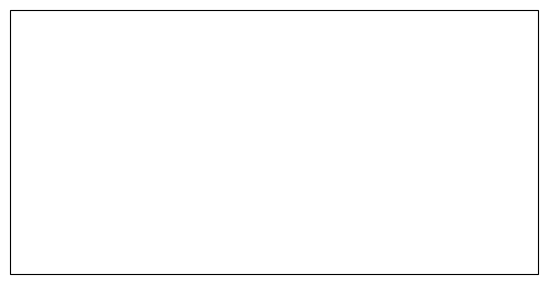

In [6]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
pc = ax1.pcolormesh(
    model_data.lon, model_data.lat, 
    model_data.mean('time').where(model_basin_mask).vol_discharge,
    cmap='Reds'
    )
fig.colorbar(pc)
ax1.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
s = ax2.scatter(
    grdc.geo_x, grdc.geo_y,
    c=grdc.runoff_mean.mean('time'),
    cmap='Reds'
    )
ax2.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)
fig.colorbar(s)
for ax in [ax1, ax2]:
    ax.set_extent([region.long_org.min()-5, region.long_org.max()+5, region.lat_org.min()-5, region.lat_org.max()+5], crs=ccrs.PlateCarree())
    ax.coastlines("10m", linewidth=0.5)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    # axis.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

In [24]:
lat_fine = np.arange(model_data.lat.min(), model_data.lat.max()+0.25, 0.25)
lon_fine = np.arange(model_data.lon.min(), model_data.lon.max()+0.25, 0.25)

model_data_fine_vol_discharge = model_data.vol_discharge.interp({'lon': lon_fine, 'lat': lat_fine})

In [35]:
model_gauge_dsch

<xarray.Dataset>
Dimensions:        (id: 1, time: 14610)
Coordinates:
  * id             (id) int32 4146185
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
Data variables:
    rv_o_h2o       (id, time) float64 1.455e-05 1.395e-05 ... 2.045e-05
    vol_discharge  (id, time) float64 34.06 32.66 29.13 ... 19.05 16.11 47.88
    pr             (id, time) float64 1.479e-05 9.268e-05 ... 0.0003532
    lat            (id) float64 47.54
    lon            (id) float64 -124.3

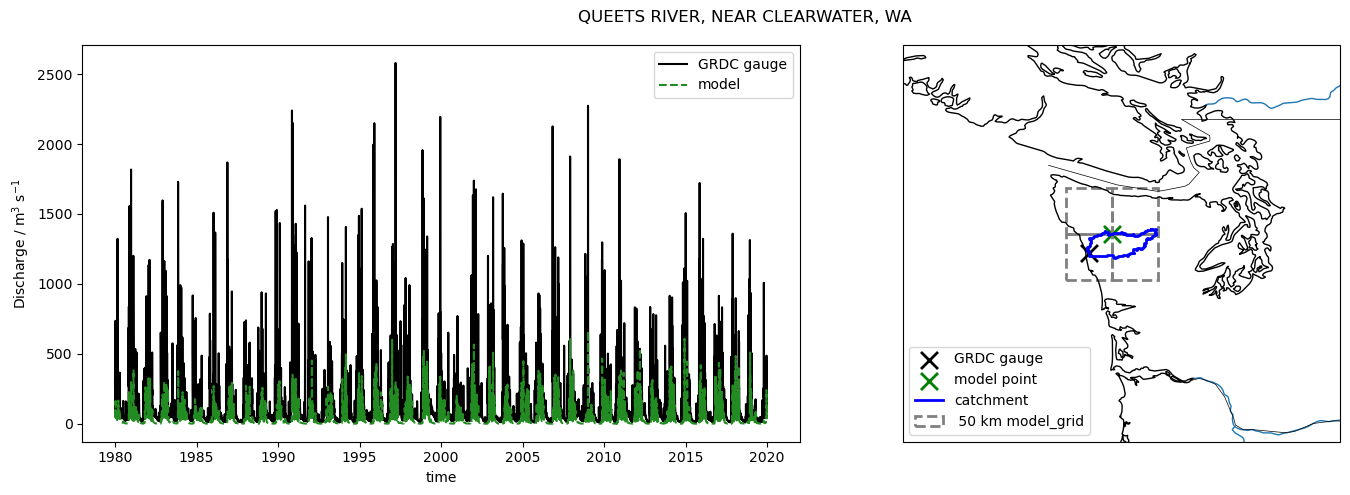

In [7]:
for i, basin in list(region.iterrows()):
    model_basin_mask = xr.DataArray(
        data=np.array([[basin.geometry.contains(Point(lon, lat)) 
                        for lon in model_data.lon] 
                    for lat in model_data.lat]).squeeze(),
        coords=(model_data.lat, model_data.lon)
        )

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)

    model_dsch = model_data.vol_discharge#.where(model_basin_mask).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    # model_dsch_p2K = model_data_p2K.vol_discharge.where(model_basin_mask).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    model_dsch['dist_to_gauge'] = haversine(basin.lat_org, basin.long_org, model_dsch.lat, model_dsch.lon)
    model_time_mask = np.isin(model_dsch.time, grdc.time)
    obs_time_mask = np.isin(grdc.time, model_dsch.time)
    obs_dsch = grdc.runoff_mean.isel(time=obs_time_mask)
    dist_stack = model_dsch.stack(dist=('lat', 'lon'))
    if len(dist_stack.dist) == 0:
        print(f"No data points in basin {i}.")
        continue
    dist_stack = dist_stack.sortby(dist_stack.dist_to_gauge)
    nearest_lat, nearest_lon = dist_stack.dropna('dist').isel(dist=0).lat, dist_stack.dropna('dist').isel(dist=0).lon
    model_dsch_nearest = model_dsch.isel(time=model_time_mask).sel(lat=nearest_lat, lon=nearest_lon)
    # model_dsch_nearest_p2K = model_dsch_p2K.isel(time=model_time_mask).sel(lat=nearest_lat, lon=nearest_lon)
    dist_gauge_model = haversine(basin.lat_org, basin.long_org, model_dsch_nearest.lat, model_dsch_nearest.lon) 
    ax1.plot(
        obs_dsch.time, 
        obs_dsch.sel(id=basin.grdc_no), 
        color='black', label='GRDC gauge')
    # ax1.plot(
    #     model_dsch.time.isel(time=np.arange(0, 365)), 
    #     model_dsch.isel(time=np.arange(0, 365)).sum(['lat', 'lon']),
    #     color='red', ls='--', label='basin sum of model discharge')
    ax1.plot(
        model_dsch_nearest.time,
        model_dsch_nearest,
        color='forestgreen', ls='--', label='model')
    # ax1.plot(
    #     model_dsch_nearest_p2K.time,
    #     model_dsch_nearest_p2K,
    #     color='orangered', ls='--', label='model p2K')
    ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    vmin = np.min([(model_dsch_nearest*86400).sum('time'), 
                   (obs_dsch.sel(id=basin.grdc_no)*86400).sum('time')])
    vmin = vmin / 2
    vmax = np.max([(model_dsch_nearest*86400).sum('time'), 
                   (obs_dsch.sel(id=basin.grdc_no)*86400).sum('time')])
    vmax = vmax * 2
    # s1 = ax2.scatter(
    #     model_dsch_nearest.lon, model_dsch_nearest.lat, 
    #     c=(model_dsch_nearest*86400).sum('time'),
    #     cmap='Reds', s=150, marker='s', label='model',
    #     vmin=vmin, vmax=vmax
    #     )
    # s2 = ax2.scatter(
    #     basin.long_org, basin.lat_org,
    #     c=(obs_dsch.sel(id=basin.grdc_no)*86400).sum('time'),
    #     cmap='Reds', s=150, marker='o', label='GRDC gauge',
    #     vmin=vmin, vmax=vmax)
    s3 = ax2.scatter(
        basin.long_org, basin.lat_org,
        color='black', marker='x', s=150, label='GRDC gauge', lw=2,
    )
    s3 = ax2.scatter(
        model_dsch_nearest.lon, model_dsch_nearest.lat,
        color='green', marker='x', s=150, label='model point', lw=2,
    )
    # fig.colorbar(s1, label='Annual discharge / m$^{3}$')
    xx, yy = basin.geometry.exterior.coords.xy
    ax2.plot(xx, yy, color='blue', lw=2, label='catchment')
    # ax2.text(
    #     0.5, 0.9, 
    #     f'distance(gauge-model):{np.round(dist_gauge_model.values, 2)} km', 
    #     transform=ax2.transAxes)
    Rec_list = [Rectangle(
        (model_dsch_nearest.lon+0.5*flon, 
         model_dsch_nearest.lat+0.5*flat), 
        0.5, 0.5, edgecolor='grey', ls='--', fill=False, lw=2)
        for flon, flat in zip([0, 0, -1, -1], [0, -1, 0, -1])]
    Rec_list[-1].set_label(' 50 km model_grid')
                
    [ax2.add_patch(R) for R in Rec_list]
    ax2.legend(loc='lower left')
    # ax1.set(title=f'Daily discharge {model_dsch_nearest["time.year"].values[0]}')
    # ax2.set(title=f'Total annual discharge {model_dsch_nearest["time.year"].values[0]}')
    fig.suptitle(f"{basin.river}, {basin.station}")

    ax1.legend()
    ax1.set(xlabel='time', ylabel='Discharge / m$^{3}$ s$^{-1}$')
    for ax in [ax2]:
        edge = 2
        ax.set_extent([np.min(xx)-edge, np.max(xx)+edge, np.min(yy)-edge, np.max(yy)+edge], crs=ccrs.PlateCarree())
        ax.coastlines("10m", linewidth=1)
        # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=1)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
    plt.tight_layout()

In [8]:
era5_data_nearest = era5_data.isel(time=model_time_mask).sel(lat=nearest_lat.values, lon=nearest_lon.values, method='nearest')
model_nearest = model_data.isel(time=model_time_mask).sel(lat=nearest_lat, lon=nearest_lon)

In [107]:
model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon}).values

array(2.3481462e+09, dtype=float32)

In [38]:
obs_dsch.sel(id=basin.grdc_no) / model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon})*86400

<xarray.DataArray (time: 14610)>
array([0.01135688, 0.01041916, 0.00815822, ..., 0.00302157, 0.00297988,
       0.01594132])
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    id             int32 4146185
    lat            float64 47.75
    lon            float64 -124.1
    dist_to_gauge  float64 30.27
    dist           object (47.75, -124.06249999999997)

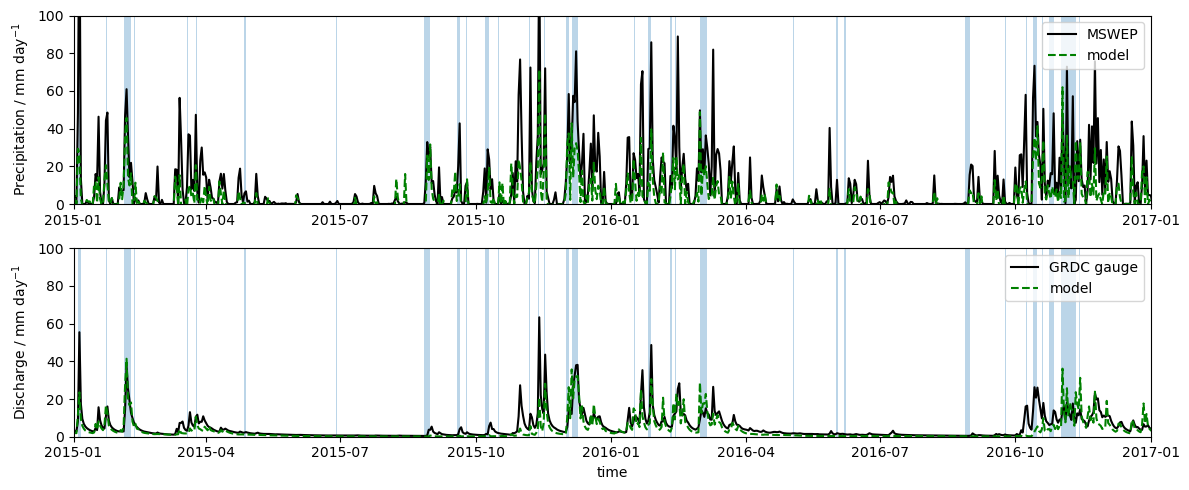

In [66]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(211)
ax1.plot(
        era5_data_nearest.time, 
        era5_data_nearest.pr*86400, 
        color='black', label='MSWEP')
ax1.plot(
        model_nearest.time,
        (model_nearest.pr - model_nearest.evap_land)*86400,
        color='green', label='model', ls='--')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(
        obs_dsch.time, 
        obs_dsch.sel(id=basin.grdc_no) *1000/ model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon})*86400, 
        color='black', label='GRDC gauge')
ax2.plot(
        model_dsch_nearest.time,
        (model_nearest.rv_o_h2o + model_nearest.rv_d_h2o)*86400,
        color='green', label='model', ls='--')
ax1.fill_between(
        model_nearest.time, 
        np.zeros(model_nearest.time.shape), np.ones(model_nearest.time.shape)*150, where=model_nearest.ar_shape == 1,
        alpha=0.3) 
ax2.fill_between(
        model_nearest.time, 
        np.zeros(model_nearest.time.shape), np.ones(model_nearest.time.shape)*150, where=model_nearest.ar_shape == 1,
        alpha=0.3) 
ax1.set(ylabel='Precipitation / mm day$^{-1}$', 
        xlim=[np.datetime64('2015-01-01'), np.datetime64('2017-01-01')], 
        ylim=[0, 100])
ax1.legend(loc='upper right')
ax2.set(xlabel='time',
        ylim=[0, 100], 
        ylabel='Discharge / mm day$^{-1}$',)
ax2.legend(loc='upper right')
plt.tight_layout()


In [134]:
model_nearest.time.where(model_nearest.ar_shape == 1).dropna('time')

<xarray.DataArray 'time' (time: 2713)>
array(['1980-01-11T00:00:00.000000000', '1980-01-12T00:00:00.000000000',
       '1980-01-31T00:00:00.000000000', ...,
       '2019-12-20T00:00:00.000000000', '2019-12-28T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    lat            float64 47.75
    lon            float64 -124.1
  * time           (time) datetime64[ns] 1980-01-11 1980-01-12 ... 2019-12-31
    dist_to_gauge  float64 30.27
    dist           object (47.75, -124.06249999999997)

In [171]:
obs_dsch.sel(id=basin.grdc_no).mean('time')* 1000 / model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon})*86400

<xarray.DataArray ()>
array(4.69707931)
Coordinates:
    id             int32 4146185
    lat            float64 47.75
    lon            float64 -124.1
    dist_to_gauge  float64 30.27
    dist           object (47.75, -124.06249999999997)

In [9]:
((model_nearest.rv_o_h2o.mean('time') + model_nearest.rv_d_h2o.mean('time') - 
  obs_dsch.sel(id=basin.grdc_no).mean('time')* 1000 / model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon})) /
 (obs_dsch.sel(id=basin.grdc_no).mean('time')* 1000 / model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon}))).values

array(-0.30376108)

In [10]:
((model_nearest.pr.mean() - era5_data_nearest.pr.mean()) / era5_data_nearest.pr.mean()).values

array(-0.44145672)

In [44]:
model_pr_nearest.mean('time') / era5_data_nearest.pr.mean('time')

<xarray.DataArray 'pr' ()>
array(0.55854328)
Coordinates:
    lat            float64 47.75
    dist_to_gauge  float64 30.27
    dist           object (47.75, -124.06249999999997)

In [12]:
sharc_base_path = '/archive/Marc.Prange/LM4p2_SHARC'
sharc_exp_name = 'clearwater_lm4sharc_ksat002_angle087rad_ep20_114y'

sharc_data = arp.load_sharc_composite_ds(
    start_year=1979, end_year=2014, base_path=sharc_base_path, exp_name=sharc_exp_name, min_precip=0, ar_str='AR_days', precip_var='pr')

model_data_comp = arp.load_loc_composite_ds(
    start_year=1979, end_year=2014, base_path='/archive/Marc.Prange/', 
    exp_name='c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020', 
    loc_name='clearwater', min_precip=0, ar_str='AR_days')

obs_data_comp = arp.load_loc_composite_ds(
    start_year=1980, end_year=2014, base_path='/archive/Marc.Prange/', 
    exp_name='c192_obs', 
    loc_name='clearwater', min_precip=0, ar_str='AR_days')

land_static = arp.lon_360_to_180(xr.open_dataset(
    '/archive/Ming.Zhao/awg/2022.03/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/gfdl.ncrc4-intel-prod-openmp/pp/land/land.static.nc'
    )).sel({'lat': model_data_comp.lat, 'lon': model_data_comp.lon})
land_static.mrsofc.values

array(4390., dtype=float32)

In [17]:
obs_data_comp.strong_precip_date[0, :].values

array(['1980-01-07T00:00:00.000000000', '1980-01-08T00:00:00.000000000',
       '1980-01-09T00:00:00.000000000', '1980-01-10T00:00:00.000000000',
       '1980-01-11T00:00:00.000000000', '1980-01-12T00:00:00.000000000',
       '1980-01-13T00:00:00.000000000', '1980-01-14T00:00:00.000000000',
       '1980-01-15T00:00:00.000000000', '1980-01-16T00:00:00.000000000',
       '1980-01-17T00:00:00.000000000'], dtype='datetime64[ns]')

In [23]:
# era5_data_nearest_ar = era5_data_nearest.isel(time=np.isin(era5_data_nearest.time, model_data_comp.strong_precip_date[:, 5]))
obs_dsch_basin_ar = obs_dsch.sel(id=basin.grdc_no).isel(time=np.isin(obs_dsch.time, obs_data_comp.strong_precip_date[:, 5]))
obs_dsch_basin_ar = obs_dsch_basin_ar * 1000 / model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon})

In [19]:
model_plot_params = {
    'ts': {
        'var': 'ts',
        'label': 'Ts / °C',
        'scaling': 1,
        'offset': -273.15,
        'vmin': -10,
        'vmax': 10,
        'cmap_day': 5,
        'cmap': 'coolwarm',
    },
    'mrso': {
        'var': 'mrso',
        'label': 'soil saturation / -',
        'scaling': land_static.mrsofc**-1,
        'offset': 0,
        'vmin': 0.95,
        'vmax': 1,
        'cmap_day': 4,
        'cmap': 'viridis',
    },
    'mrsos': {
        'var': 'mrsos',
        'label': 'mrsos / kg m$^{-2}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 0,
        'vmax': 45,
        'cmap_day': 4,
        'cmap': 'viridis',
    },
    'snow': {
        'var': 'snw',
        'label': 'snow / kg m$^{-2}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 0,
        'vmax': 100,
        'cmap_day': 5,
        'cmap': 'viridis',
    },
}

sharc_plot_params = {
    'ts': {
        'var': 't_surf',
        'label': 'Ts / °C',
        'scaling': 1,
        'offset': -273.15,
        'vmin': -10,
        'vmax': 10,
        'cmap_day': 5,
        'cmap': 'coolwarm',
    },
    'mrso': {
        'var': 'soil_liq',
        'ptid': 1,
        'zfull_soil': 0,
        'label': 'soil_liq top layer / kg m$^{-3}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 100,
        'vmax': 500,
        'cmap_day': 4,
        'cmap': 'viridis',
    },
    'mrsos': {
        'var': 'soil_liq',
        'ptid': 1,
        'zfull_soil': 0,
        'label': 'soil_liq top layer / kg m$^{-3}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 100,
        'vmax': 500,
        'cmap_day': 4,
        'cmap': 'viridis',
    },
    'snow': {
        'var': 'snow',
        'ptid': 1,
        'label': 'snow / kg m$^{-2}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 0,
        'vmax': 100,
        'cmap_day': 5,
        'cmap': 'viridis',
    },
}

/tmp/ipykernel_113251/3794093005.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  s1 = axs[0].scatter(
/tmp/ipykernel_113251/3794093005.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  s2 = axs[1].scatter(


[Text(0.5, 0, 'AR precip / mm day$^{-1}$'),
 Text(0, 0.5, 'discharge / mm day$^{-1}$'),
 Text(0.5, 1.0, 'LM4.2 SHARC'),
 (-5.0, 150.0),
 (-5.0, 150.0)]

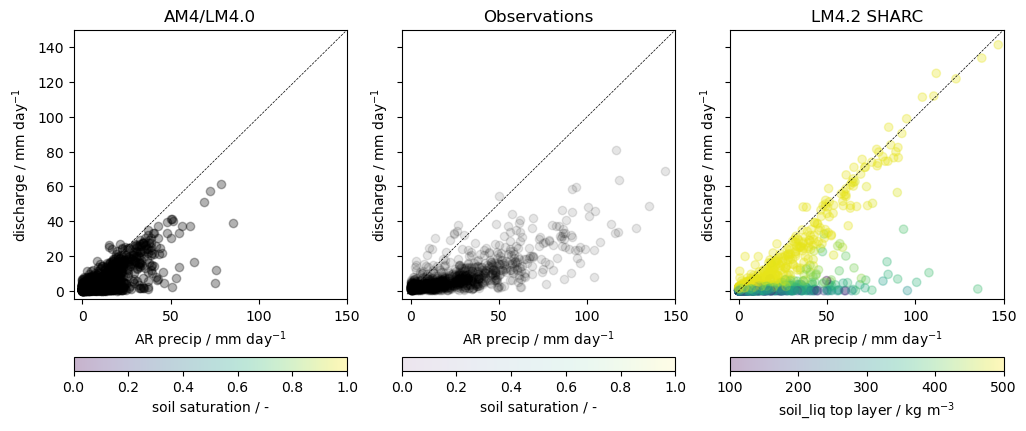

In [25]:
plot_var = 'mrso'
params = model_plot_params[plot_var]
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 5))
axs[0].plot(np.arange(-2, 150), np.arange(-2, 150), 'k--', lw=0.5)
s1 = axs[0].scatter(
    (model_data_comp.pr[:, 5])*86400, 
     (model_data_comp.rv_d_h2o + model_data_comp.rv_o_h2o)[:, 5]*86400,
    c='k',#(model_data_comp[params["var"]][:, params["cmap_day"]] + params["offset"]) * params["scaling"],
    alpha=0.3, vmin=params["vmin"], vmax=params["vmax"], cmap=params["cmap"])
plt.colorbar(s1, orientation='horizontal', label=params["label"])
# Obs
axs[1].plot(np.arange(-2, 150), np.arange(-2, 150), 'k--', lw=0.5)
s2 = axs[1].scatter(
    (obs_data_comp.pr[:, 5])*86400, 
     obs_dsch_basin_ar*86400,
    c='black',
    alpha=0.1, vmin=params["vmin"], vmax=params["vmax"], cmap=params["cmap"])
plt.colorbar(s2, orientation='horizontal', label=params['label'])
# SHARC
axs[2].plot(np.arange(-2, 150), np.arange(-2, 150), 'k--', lw=0.5)
params = sharc_plot_params[plot_var]
plot_data = sharc_data[params['var']].isel(time=params['cmap_day'])
if 'ptid' in params.keys():
    plot_data = plot_data.sel(ptid=params['ptid'])
if 'zfull_soil' in params.keys():
    plot_data = plot_data.isel(zfull_soil=params['zfull_soil'])
s3 = axs[2].scatter(
    (sharc_data.pr[:, 5]) * 86400,
    sharc_data.reach_discharge[:, 5, 0]*86400,
    c=(plot_data + params['offset']) * params['scaling'],
    alpha=0.3, vmin=params['vmin'], vmax=params['vmax'], cmap=params['cmap'])
plt.colorbar(s3, orientation='horizontal', label=params['label'])
axs[0].set(
    xlabel='AR precip / mm day$^{-1}$', ylabel='discharge / mm day$^{-1}$',
    title='AM4/LM4.0')
axs[1].set(
    xlabel='AR precip / mm day$^{-1}$', ylabel='discharge / mm day$^{-1}$',
    title='Observations')
axs[2].set(
    # xlim=[-10, 100], ylim=[-10, 100], 
    xlabel='AR precip / mm day$^{-1}$', ylabel='discharge / mm day$^{-1}$',
    title='LM4.2 SHARC',
    xlim=[-5, 150], ylim=[-5, 150])
# plt.savefig(
#     f'plots/runoff/providence_scatter_20mm_events_prli_runoff_{plot_var}_LM4_p2K_SHARC.png', 
#     dpi=300, bbox_inches='tight')

In [26]:
((model_data_comp.rv_d_h2o[:, 5] + model_data_comp.rv_o_h2o[:, 5]).mean('case')*86400).values

array(5.4793356)

In [29]:
(((model_data_comp.rv_d_h2o[:, 5] + model_data_comp.rv_o_h2o[:, 5]).mean('case')*86400).values 
 - obs_dsch_basin_ar.mean('time').values*86400)/(obs_dsch_basin_ar.mean('time').values*86400)

-0.291746834159372

In [31]:
((model_data_comp.pr[:, 5]).mean('case')*86400 - (obs_data_comp.pr[:, 5]).mean('case')*86400)/((obs_data_comp.pr[:, 5]).mean('case')*86400)

<xarray.DataArray 'pr' ()>
array(-0.54436731)
Coordinates:
    lat      float64 47.75
    time     timedelta64[ns] 00:00:00
    lon      float64 ...

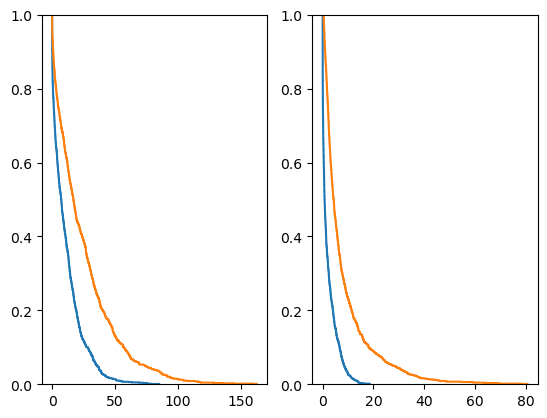

In [151]:
fig, axs = plt.subplots(ncols=2)
axs[0].ecdf(model_data_comp.pr[:, 5]*86400, complementary=True)
axs[0].ecdf(obs_data_comp.pr[:, 5]*86400, complementary=True)
axs[1].ecdf(model_data_comp.rv_o_h2o[:, 5]*86400, complementary=True)
axs[1].ecdf(obs_dsch_basin_ar*86400, complementary=True)

In [155]:
obs_dsch_basin_ar

<xarray.DataArray (time: 1128)>
array([3.1353967e-04, 7.9831916e-05, 9.7679607e-05, ..., 4.3654436e-05,
       4.7392707e-04, 7.8264296e-05], dtype=float32)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-12 1980-02-01 ... 2014-12-19
    id             int32 4146185
    lat            float64 47.75
    lon            float64 -124.1
    dist_to_gauge  float64 30.27
    dist           object (47.75, -124.06249999999997)

In [156]:
(model_data_comp.rv_o_h2o[:, 5].mean('case') - obs_dsch_basin_ar.mean('time')) / obs_dsch_basin_ar.mean('time')

<xarray.DataArray ()>
array(-0.71983874, dtype=float32)
Coordinates:
    lat            float64 47.75
    lon            float64 -124.1
    time           timedelta64[ns] 00:00:00
    id             int32 4146185
    dist_to_gauge  float64 30.27
    dist           object (47.75, -124.06249999999997)

In [154]:
(model_data_comp.pr[:, 5].mean('case') - obs_data_comp.pr[:, 5].mean('case'))/obs_data_comp.pr[:, 5].mean('case')

<xarray.DataArray 'pr' ()>
array(-0.54436731)
Coordinates:
    lat      float64 47.75
    time     timedelta64[ns] 00:00:00
    lon      float64 ...